## SMS Spam Detection
Predict if a SMS is HAM or SPAM after analyzing the text through Naive Bayes classifier algorithm

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
messages = pd.read_csv('./message/sms_spam.csv', names=['label', 'message'])

In [13]:
messages.head()

,label,message
0,type,text
1,ham,Hope you are having a good week. Just checking in
2,ham,K..give back my thanks.
3,ham,Am also doing in cbe only. But have to pay.
4,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."


In [14]:
messages = messages.iloc[1:]

In [15]:
messages.head()

,label,message
1,ham,Hope you are having a good week. Just checking in
2,ham,K..give back my thanks.
3,ham,Am also doing in cbe only. But have to pay.
4,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
5,spam,okmail: Dear Dave this is your final notice to...


In [16]:
messages.describe()

,label,message
count,5559,5559
unique,2,5156
top,ham,"Sorry, I'll call later"
freq,4812,30


In [17]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 1 to 5559
Data columns (total 2 columns):
label      5559 non-null object
message    5559 non-null object
dtypes: object(2)
memory usage: 86.9+ KB


In [18]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4812   4503                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [20]:
# check the length of the text messages
messages['length'] = messages['message'].apply(len)

In [21]:
messages.head()

,label,message,length
1,ham,Hope you are having a good week. Just checking in,49
2,ham,K..give back my thanks.,23
3,ham,Am also doing in cbe only. But have to pay.,43
4,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149
5,spam,okmail: Dear Dave this is your final notice to...,161


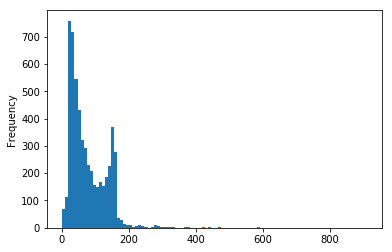

In [22]:
# visualization
messages['length'].plot(bins=100, kind='hist');

In [23]:
messages.length.describe()

count    5559.000000
mean       79.781436
std        59.105497
min         2.000000
25%        35.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

In [25]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

See if message length is a distinguishing feature between ham and spam

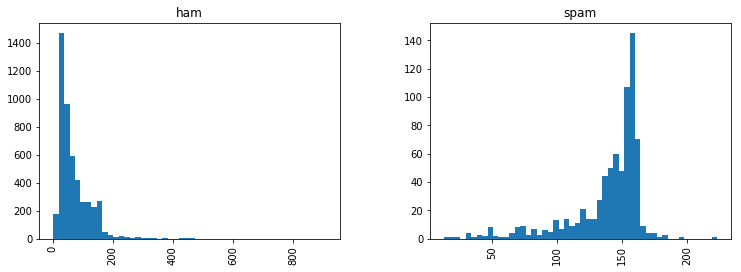

In [28]:
messages.hist(column='length', by='label',bins=50, figsize=(12,4));

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation. We can import a list of english stopwords from NLTK and then remove all of them.


In [29]:
import string
from nltk.corpus import stopwords

In [30]:
def text_process(mess):
    # Check characters to see if they are in punctuations
    non_punc = [char for char in mess if char not in string.punctuation]
    # join characters again to form string
    non_punc = ''.join(non_punc)
    # remove any stopwords
    return [word for word in non_punc.split() if word.lower() not in stopwords.words('english')]

In [31]:
messages['message'].head(5).apply(text_process)

1                         [Hope, good, week, checking]
2                                [Kgive, back, thanks]
3                                     [also, cbe, pay]
4    [complimentary, 4, STAR, Ibiza, Holiday, £1000...
5    [okmail, Dear, Dave, final, notice, collect, 4...
Name: message, dtype: object

Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's CountVectorizer. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

11355


Now we can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [35]:
messages_bow = bow_transformer.transform(messages['message'])

In [36]:
print("Shape of Sparse Matrix: ",messages_bow.shape)
print("Amount of Non-zero Occurences: ",messages_bow.nnz)

Shape of Sparse Matrix:  (5559, 11355)
Amount of Non-zero Occurences:  50013


In [37]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


### TF-IDF
The tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.


In [38]:
from sklearn.feature_extraction.text import TfidfTransformer

In [39]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
message_tfidf = tfidf_transformer.transform(messages_bow)
print(message_tfidf.shape)

(5559, 11355)


### Training a Model

In [40]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(message_tfidf, messages['label'])

### Model Evaluation

In [41]:
predictions = model.predict(message_tfidf)
print(predictions)

['ham' 'ham' 'ham' ... 'spam' 'spam' 'ham']


In [42]:
from sklearn.metrics import classification_report
print(classification_report(messages['label'], predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4812
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5559
   macro avg       0.99      0.92      0.95      5559
weighted avg       0.98      0.98      0.98      5559



There are quite a few possible metrics for evaluating model performance. Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mis-predicting "spam" as "ham" is probably much lower than mis-predicting "ham" as "spam".

In the above "evaluation",we evaluated accuracy on the same data we used for training. You should never actually evaluate on the same dataset you train on!

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the training data during its model fitting and parameter tuning. The test data is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

In [43]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4447 1112 5559


### Creating a Pipeline

In [44]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [45]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x1a2a6b87b8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [46]:
predictions = pipeline.predict(msg_test)

In [47]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98       994
        spam       0.77      0.99      0.87       118

    accuracy                           0.97      1112
   macro avg       0.89      0.98      0.93      1112
weighted avg       0.98      0.97      0.97      1112



Now we have a classification report for our model on a true testing set! Looking into precision and recall i can say that this basic model prediction is pretty well. The precision of spam is less then expected i believe this is because we have very less spam message in our training set compare to ham message.

### End